### Tutorial 5: Support Vector Machine 

to support our learning in Lecture 14. Bayesian neural network in EE2102575

by *Suwichaya Suwanwimolkul, Ph.D.*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GabbySuwichaya/Statistical-Learning-EE575/blob/master/Tutorial5/main.ipynb)

SVM does not support multiclass classification natively. Two commonly used approaches that extend SVM for multiclass classification are One-vs-One and One-vs-Rest. 

In this exercise, we would like you to apply multiclass classification using SVM to classify number 0-10 from MNIST dataset. 
 
Specifically, we would like you to explore the following:  

Table of contents

- [Tasks](#tasks)
- [1. Histogram plots](#1-histogram-plots)  to ensure that you have chosen the samples evenly from each class. 
    - You may randomly select 6000 samples for training and 1000 sample for testing.  
    - Then, show the distribution of labels in the selected training and testing samples.

- [2. Training and model selection](#2-training-and-model-selection)

    Let's assume that we choose the RBF kernel for SVM. 

    - You may separate your training set for tuning and validation. 
    - Show the following results:
        - The accuracy (or loss ) curves across of the validation set across different kernels and model parameters. 
        - Pick the best set of parameters and verify the final performance on the testing dataset.  

- [3. One-vs-One and One-vs-Rest](#3-one-vs-one-vs-one-vs-the-rest)

    To see the differences between One-vs-one and One-vs-the rest. Let’s observe the positive and negative supports.  
    
    - 3.a. one-vs-one classification
        - What is the number of supports and how is it related to the number of classes? 
        - Observe the positive and negative supports of the first separation, the last separation, and any where in the middle.
    - 3.b. one-vs-rest classification 
        - same question for the supports and number of classes. 
        - Also, observe the positive and negative supports of the first separation,  the last separation, and any where inbetween.
    

- [4. Visualization](#4-visualize-the-supports-positive-and-negative-supports)

    Can you tell the differences between the observation in (3.a) and (3.b)? 
    
    - For each observation, you may plot the mean shapes of the positive and negative supports & the histogram of the labels associated with the positive and negative supports.

    - [Mean shapes of the negative supports](#plot-the-mean-shapes-of-the-negative-supports)

    - [Histogram of labels associated with possitive and negative supports](#calculate-the-histogram-of-the-labels-associated-with-the-positive-and-negative-supports)


In [1]:
! pip install numpy scipy pandas matplotlib sklearn tensorflow
! pip3 install torch torchvision torchaudio 

  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://g

## Tasks

#### 1. Histogram plots

- Ensure that you have chosen the samples evenly from each class. 
- Then, show the distribution of labels in the selected training and testing samples.

2024-03-03 15:21:57.350944: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-03 15:21:57.373721: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-03 15:21:57.719886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


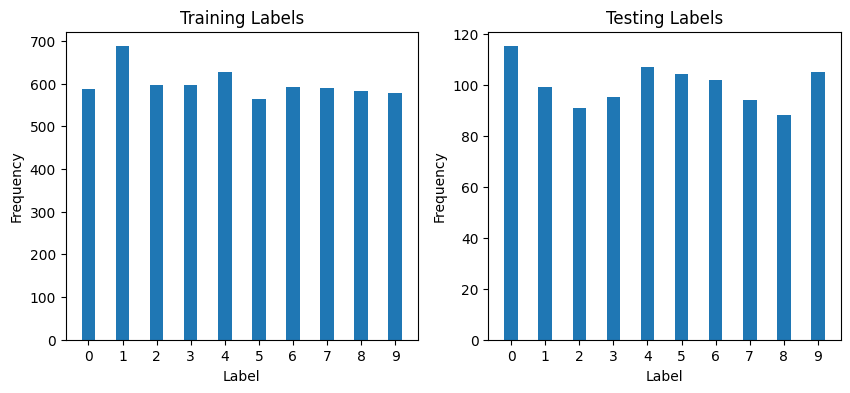

In [2]:
from scipy.stats import mode
import numpy as np
#from mnist import MNIST
from time import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib 
 
from itertools import chain
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
 
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd
import tensorflow as tf

# Load the MNIST dataset

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Sample the data and reshape it into a 2D array
seq = np.random.randint(0,60000,6000)
train_samp  = train_images[seq,:,:].reshape(-1,28*28) 
trlab_samp  = train_labels[seq] 

seq = np.random.randint(0,10000,1000)
test_samp   = test_images[seq, :,:].reshape(-1,28*28)
tslab_samp  = test_labels[seq] 
 

######################################################## 
# 1. Show the distribution of the training and testing labels. 
# [Hint] You may use `np.histogram(trlab_samp, range=[0,10])`
# to get the histogram of the training labels.

train_hist, train_bins = np.histogram(trlab_samp, range=[0,10])
test_hist, test_bins   = np.histogram(tslab_samp, range=[0,10])

ticks = range(10) 
width = 0.4
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4)) 
ax = axes[0]
ax.bar(ticks, train_hist, width, label='Training')
ax.set_xticks(ticks)
ax.set_ylabel('Frequency')
ax.set_xlabel('Label')
ax.set_title('Training Labels')
 
ax = axes[1] 
ax.bar(ticks, test_hist, width, label='Testing')
ax.set_xticks(ticks)
ax.set_ylabel('Frequency')
ax.set_xlabel('Label')
ax.set_title('Testing Labels')  
fig.savefig("SVM_1_MNIST_label_distribution.png")

### 2. Training and model selection

- You may separate your training set for tuning and validation. 
- Show the following results:
    - Show the accuracy (or loss ) curves across of the validation set across different kernels and model parameters. 
    - Pick the best set of parameters and verify the final performance on the testing dataset.  

{'C': 0.01, 'gamma': 1.0, 'Train': 5.477142195540817, 'Val': 5.309274013266821, 'ACC_tra': 0.115, 'ACC_val': 0.1125, 'ACC_test': 0.099}
{'C': 0.1, 'gamma': 1.0, 'Train': 5.446521714452109, 'Val': 5.276828752240892, 'ACC_tra': 0.115, 'ACC_val': 0.1125, 'ACC_test': 0.099}
{'C': 0.5, 'gamma': 1.0, 'Train': 2.3341683260821084, 'Val': 2.237531459984973, 'ACC_tra': 0.19375, 'ACC_val': 0.19916666666666666, 'ACC_test': 0.099}
{'C': 1.0, 'gamma': 1.0, 'Train': 0.0, 'Val': 0.0, 'ACC_tra': 1.0, 'ACC_val': 1.0, 'ACC_test': 0.099}
{'C': 2.0, 'gamma': 1.0, 'Train': 0.0, 'Val': 0.0, 'ACC_tra': 1.0, 'ACC_val': 1.0, 'ACC_test': 0.099}
{'C': 2.5, 'gamma': 1.0, 'Train': 0.0, 'Val': 0.0, 'ACC_tra': 1.0, 'ACC_val': 1.0, 'ACC_test': 0.099}


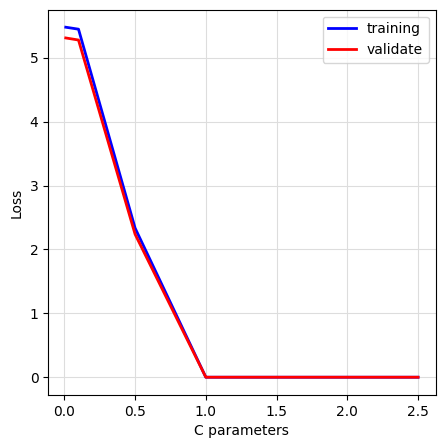

In [3]:
######################################################## 
# 2. Training and model selection

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import hinge_loss

c_list = [0.01, 0.1, 0.5, 1.0, 2.0, 2.5] 
g_list = [1.0]

# [Hint] You can also recheck your result with GridSearchCV. For example .... 
''' 
gamma_list = [0.01, 0.1, 1]
c_list     = [0.001, 0.1, 1, 10, 100]
param_grid = {'C': c_list, 'gamma':  gamma_list}

# Create a GridSearchCV object with the SVM model, hyperparameters, and custom scoring function
svc = SVC(kernel='rbf')
grid_search = GridSearchCV(svc, param_grid=param_grid, cv=5, return_train_score=True)

# Fit the GridSearchCV object to the training data
grid_search.fit(train_samp, trlab_samp)

# Get the best hyperparameters and associated training and validation losses
best_params = grid_search.best_params_ 
C = best_params['C']
gamma = best_params['gamma']
'''

sub_train_samp, val_samp, sub_trlab_samp, valab_samp = train_test_split(train_samp, trlab_samp, test_size=0.2)

tuning_ = [] 

for c in c_list:  
  for g in g_list:
    svm = SVC(kernel='rbf', C=c, gamma=g)
    # perform grid search with 5-fold cross-validation
    # Fit the estimator to the data
    svm.fit(train_samp, trlab_samp)

    # Compute the decision function on the training data
    accuracy_train = svm.score(sub_train_samp, sub_trlab_samp)

    # Compute the hinge loss on the training data
    decision_values = svm.decision_function(sub_train_samp)
    h_loss = hinge_loss(sub_trlab_samp, decision_values)

    decision_values_test = svm.decision_function(val_samp)
    v_loss               = hinge_loss(valab_samp, decision_values_test)

    accuracy = svm.score(val_samp, valab_samp)

    testing_accuracy = svm.score(test_samp, tslab_samp)

    tuning_.append({"C":c, "gamma":g,  "Train": h_loss, "Val":v_loss, 'ACC_tra' : accuracy_train, 'ACC_val' : accuracy, 'ACC_test':testing_accuracy})
    print({"C":c, "gamma":g,  "Train": h_loss, "Val":v_loss, 'ACC_tra' : accuracy_train, 'ACC_val' : accuracy, 'ACC_test':testing_accuracy})

df_tuning = pd.DataFrame(tuning_)
 
training_acc   = df_tuning['Train']
validating_acc = df_tuning['Val']

fig = plt.figure(figsize=(5,5)) 
plt.plot(c_list, training_acc, label='training',color='blue', linewidth=2.0)
plt.plot(c_list, validating_acc, label='validate',color='red', linewidth=2.0)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.xlabel("C parameters") 
plt.legend()
plt.ylabel("Loss")
fig.savefig("SVM_2_ModelSelection.png")

# You can also try .... 

# gamma_list = [0.01, 0.1, 1]
# c_list     = [0.001, 0.1, 1, 10, 100]
# param_grid = {'C': c_list, 'gamma':  gamma_list}

# # Create a GridSearchCV object with the SVM model, hyperparameters, and custom scoring function
# svc = SVC(kernel='rbf')
# grid_search = GridSearchCV(svc, param_grid=param_grid, cv=5, return_train_score=True)

# # Fit the GridSearchCV object to the training data
# grid_search.fit(train_samp, trlab_samp)

# # Get the best hyperparameters and associated training and validation losses
# best_params = grid_search.best_params_

### 3. One-vs-one vs. One-vs-the rest

To see the differences between One-vs-one and One-vs-the rest. Let’s observe the positive and negative supports.  

- a. For one-vs-one classification, what is the number of supports and how is it related to the number of classes? 
    - Observe the positive and negative supports of the first separation, the last separation, and any where in the middle.
- b. For one-vs-rest classification, same question for the supports and number of classes. 
    - Also, observe the positive and negative supports of the first separation,  the last separation, and any where inbetween.
- c. Can you tell the differences between the observation in (3.a) and (3.b)? 
    - For each observation, you may plot the mean shapes of the positive and negative supports & the histogram of 
    the labels associated with the positive and negative supports.

In [4]:
best_c = 1 # Please change the number to the best C you found in the previous step
best_gamma =  1 # Please change the number to the best C you found in the previous step

type_svm =  "one_vs_rest"  # Please change the type of SVM you want to use. You can choose either "one_vs_one" or "one_vs_rest"

# Perform the training for SVM classification
if type_svm == "one_vs_one":
  # Train One vs One [SVM model with RBF kernel]
  svm = SVC(kernel='rbf', C=best_c, gamma=best_gamma)
  svm.fit(train_samp, trlab_samp)

elif type_svm == "one_vs_rest":
  # Train One vs Rest [SVM model with RBF kernel]
  svm = SVC(kernel='rbf', C=best_c, gamma=best_gamma)
  ovr_svc = OneVsRestClassifier(svm)
  ovr_svc.fit(train_samp, trlab_samp)

### 4. Visualize the supports (positive and negative supports)

In [5]:
# Visualize the supports (positive and negative supports)

if type_svm == "one_vs_one":
  dual_coef = svm.dual_coef_
  support   = svm.support_

  print("Number of  Hyperplanes: %d" % dual_coef.shape[0])
  print("Number of  Support Coefficients: %d" % dual_coef.shape[1])
  
  class_i =  0 # 0, 8, 3<<<<   Try the first separation, the last separation, and any where inbetween ...Check with the number of  hyperplanes
  separate_i    = class_i
  pos_support = support[dual_coef[separate_i,:] > 0]
  neg_support = support[dual_coef[separate_i,:] < 0]

elif type_svm == "one_vs_rest": 
  
   
  class_i = 3  # 0, 9, 3 <<<<  Try the first separation,  the last separation, and any where inbetween ...Check with the number of hyperplanes 

  # Get indices of support vectors for each class
  binary_clf = ovr_svc.estimators_[class_i] 
  # get the dual coefficients for class 0
  dual_coef = binary_clf.dual_coef_
  support   = binary_clf.support_

  print("Number of  Hyperplanes: %d" % len(ovr_svc.estimators_))
  print("Number of  Support Coefficients: %d" % dual_coef.shape[1])

  pos_support = support[dual_coef[0,:] > 0]
  neg_support = support[dual_coef[0,:] < 0]


print(f"Number of supports for positive class: {len(pos_support)}")
print(f"Number of supports for negative class: {len(neg_support)}")
 

Number of  Hyperplanes: 10
Number of  Support Coefficients: 5748
Number of supports for positive class: 597
Number of supports for negative class: 5151


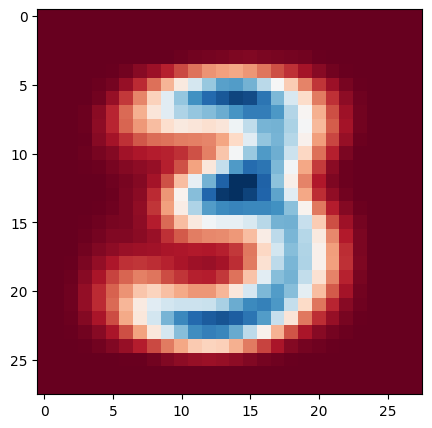

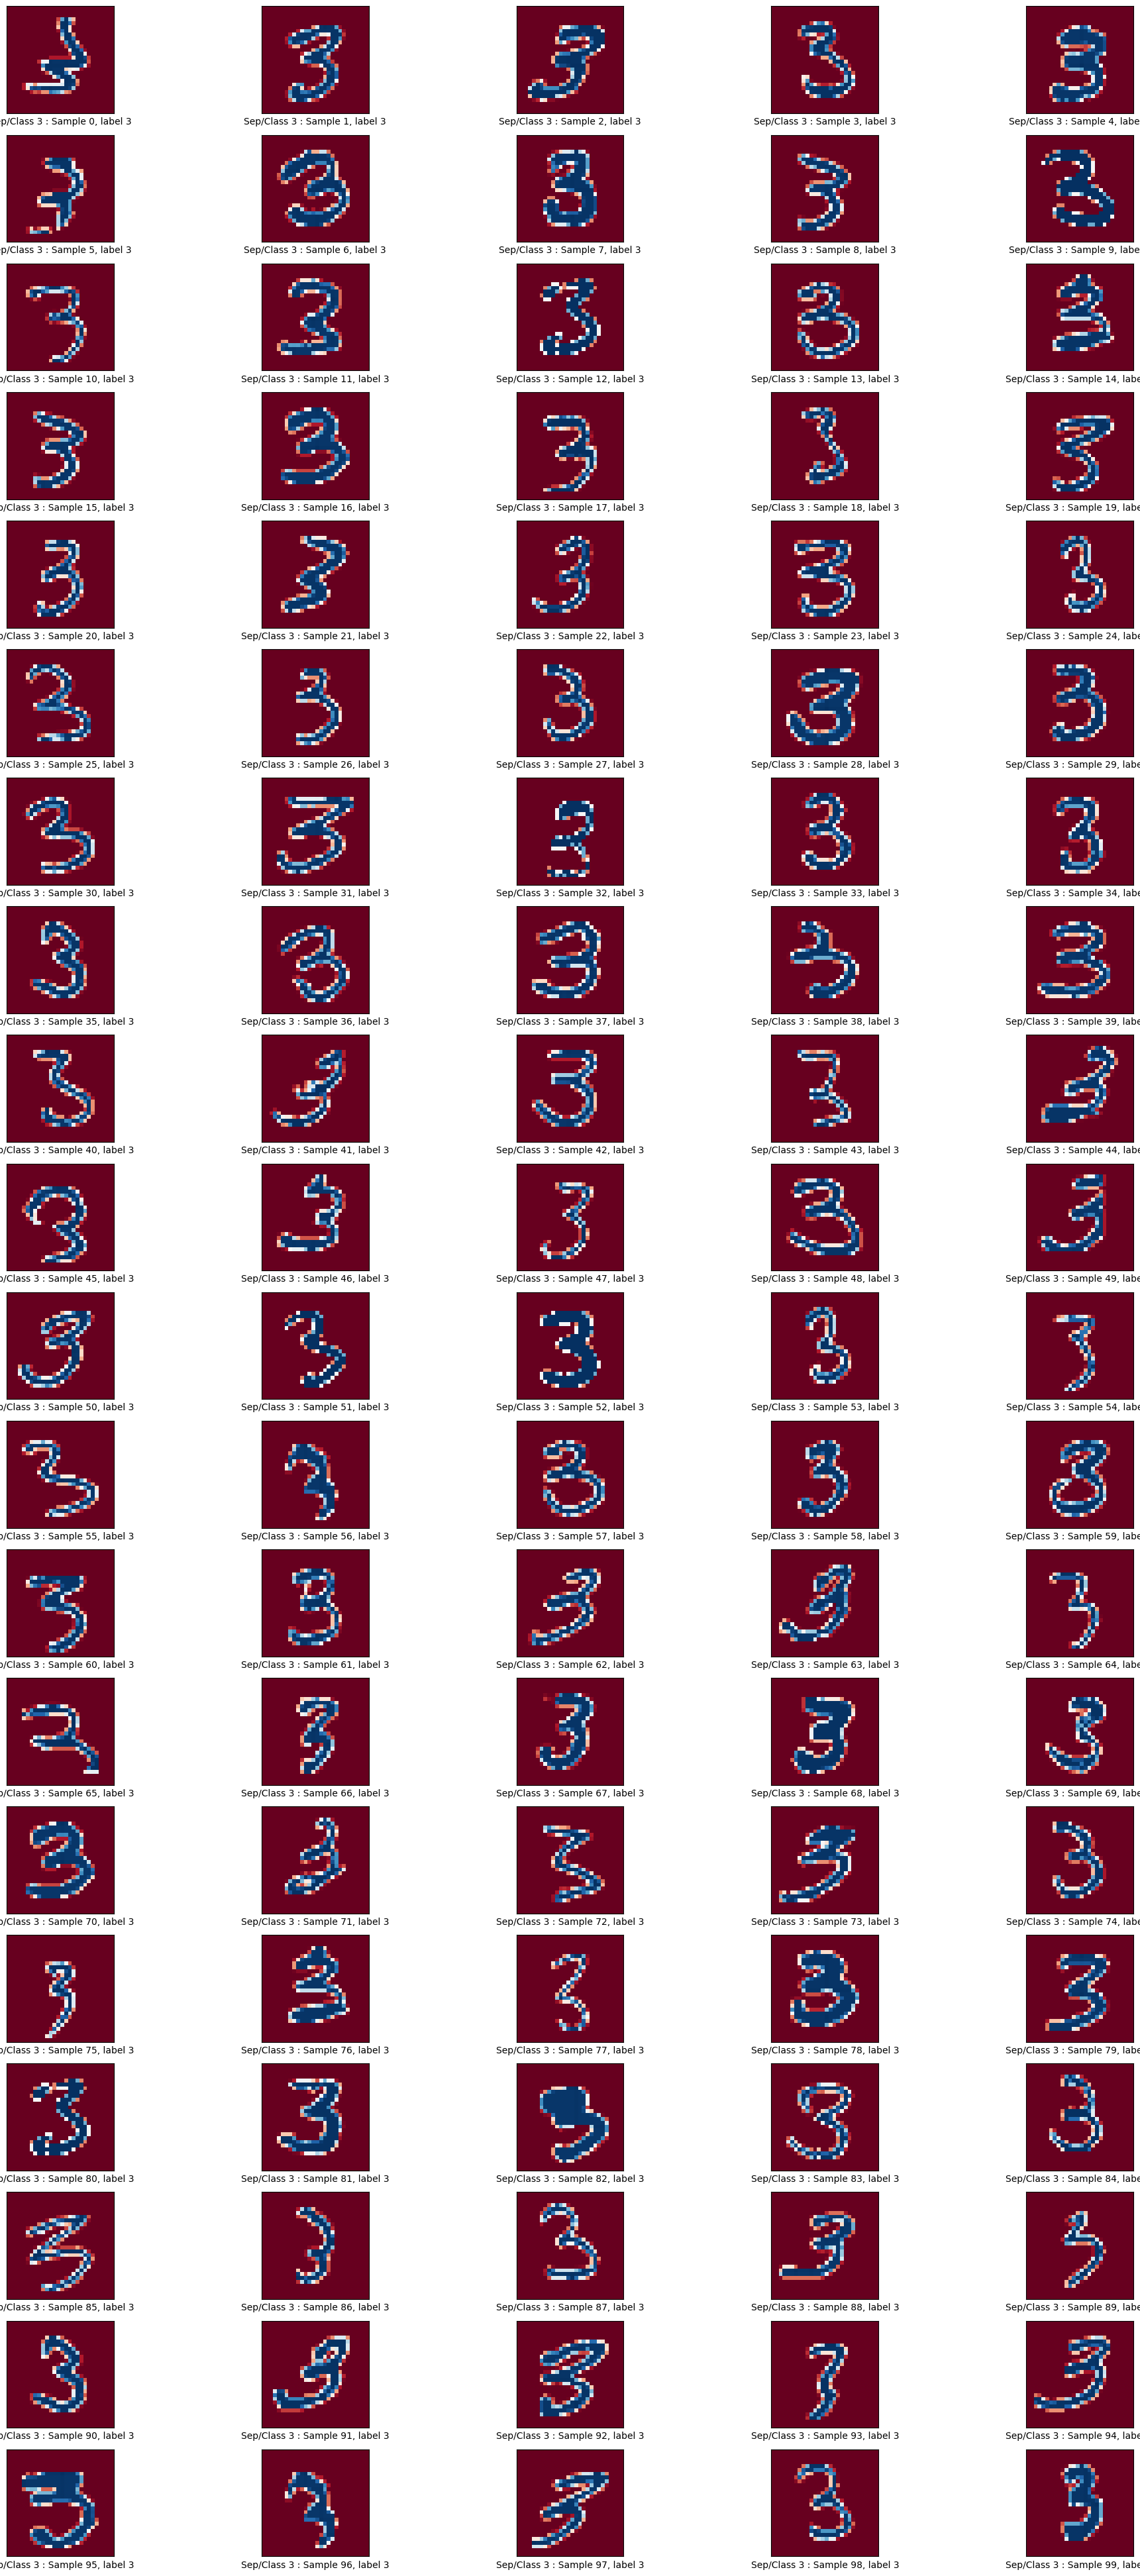

In [6]:
# Plot the mean shapes of the positive supports
pos_supp_samples = train_samp[pos_support,:]
label_pos        = trlab_samp[pos_support]

av_train = pos_supp_samples.mean(axis=0).reshape(-1, 28, 28) 
fig = plt.figure(figsize=(5,5))
plt.imshow(av_train.reshape(28, 28), cmap=plt.cm.RdBu)
fig.savefig("SVM_3_mean_positive_support_%s_%d.png" % (type_svm,class_i))

show_support = min(len(pos_support),len(neg_support))  
chosen_sample = np.random.randint(0, show_support,100)

ind = 0
fig = plt.figure(figsize=(24,50))
for i, sample_id in enumerate(chosen_sample):
  l1 = plt.subplot(int(len(chosen_sample)/5), 5, i + 1)  
  sv_image = pos_supp_samples[sample_id,:]
  sv_label = label_pos[sample_id]
  l1.imshow(sv_image.reshape(28, 28), cmap=plt.cm.RdBu)
  l1.set_xticks(())
  l1.set_yticks(())
  l1.set_xlabel('Sep/Class %d : Sample %d, label %s' % (class_i, i, str(sv_label))) 
fig.savefig("SVM_3_positive_support_%s_%d.png" % (type_svm,class_i))


#### Plot the mean shapes of the negative supports

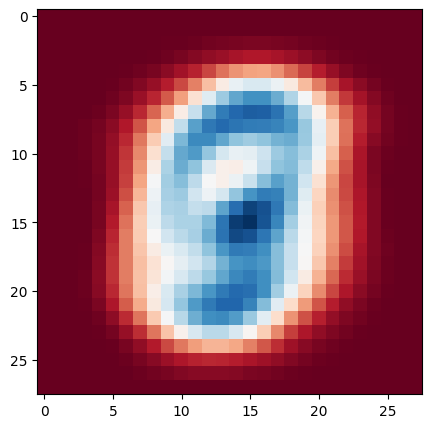

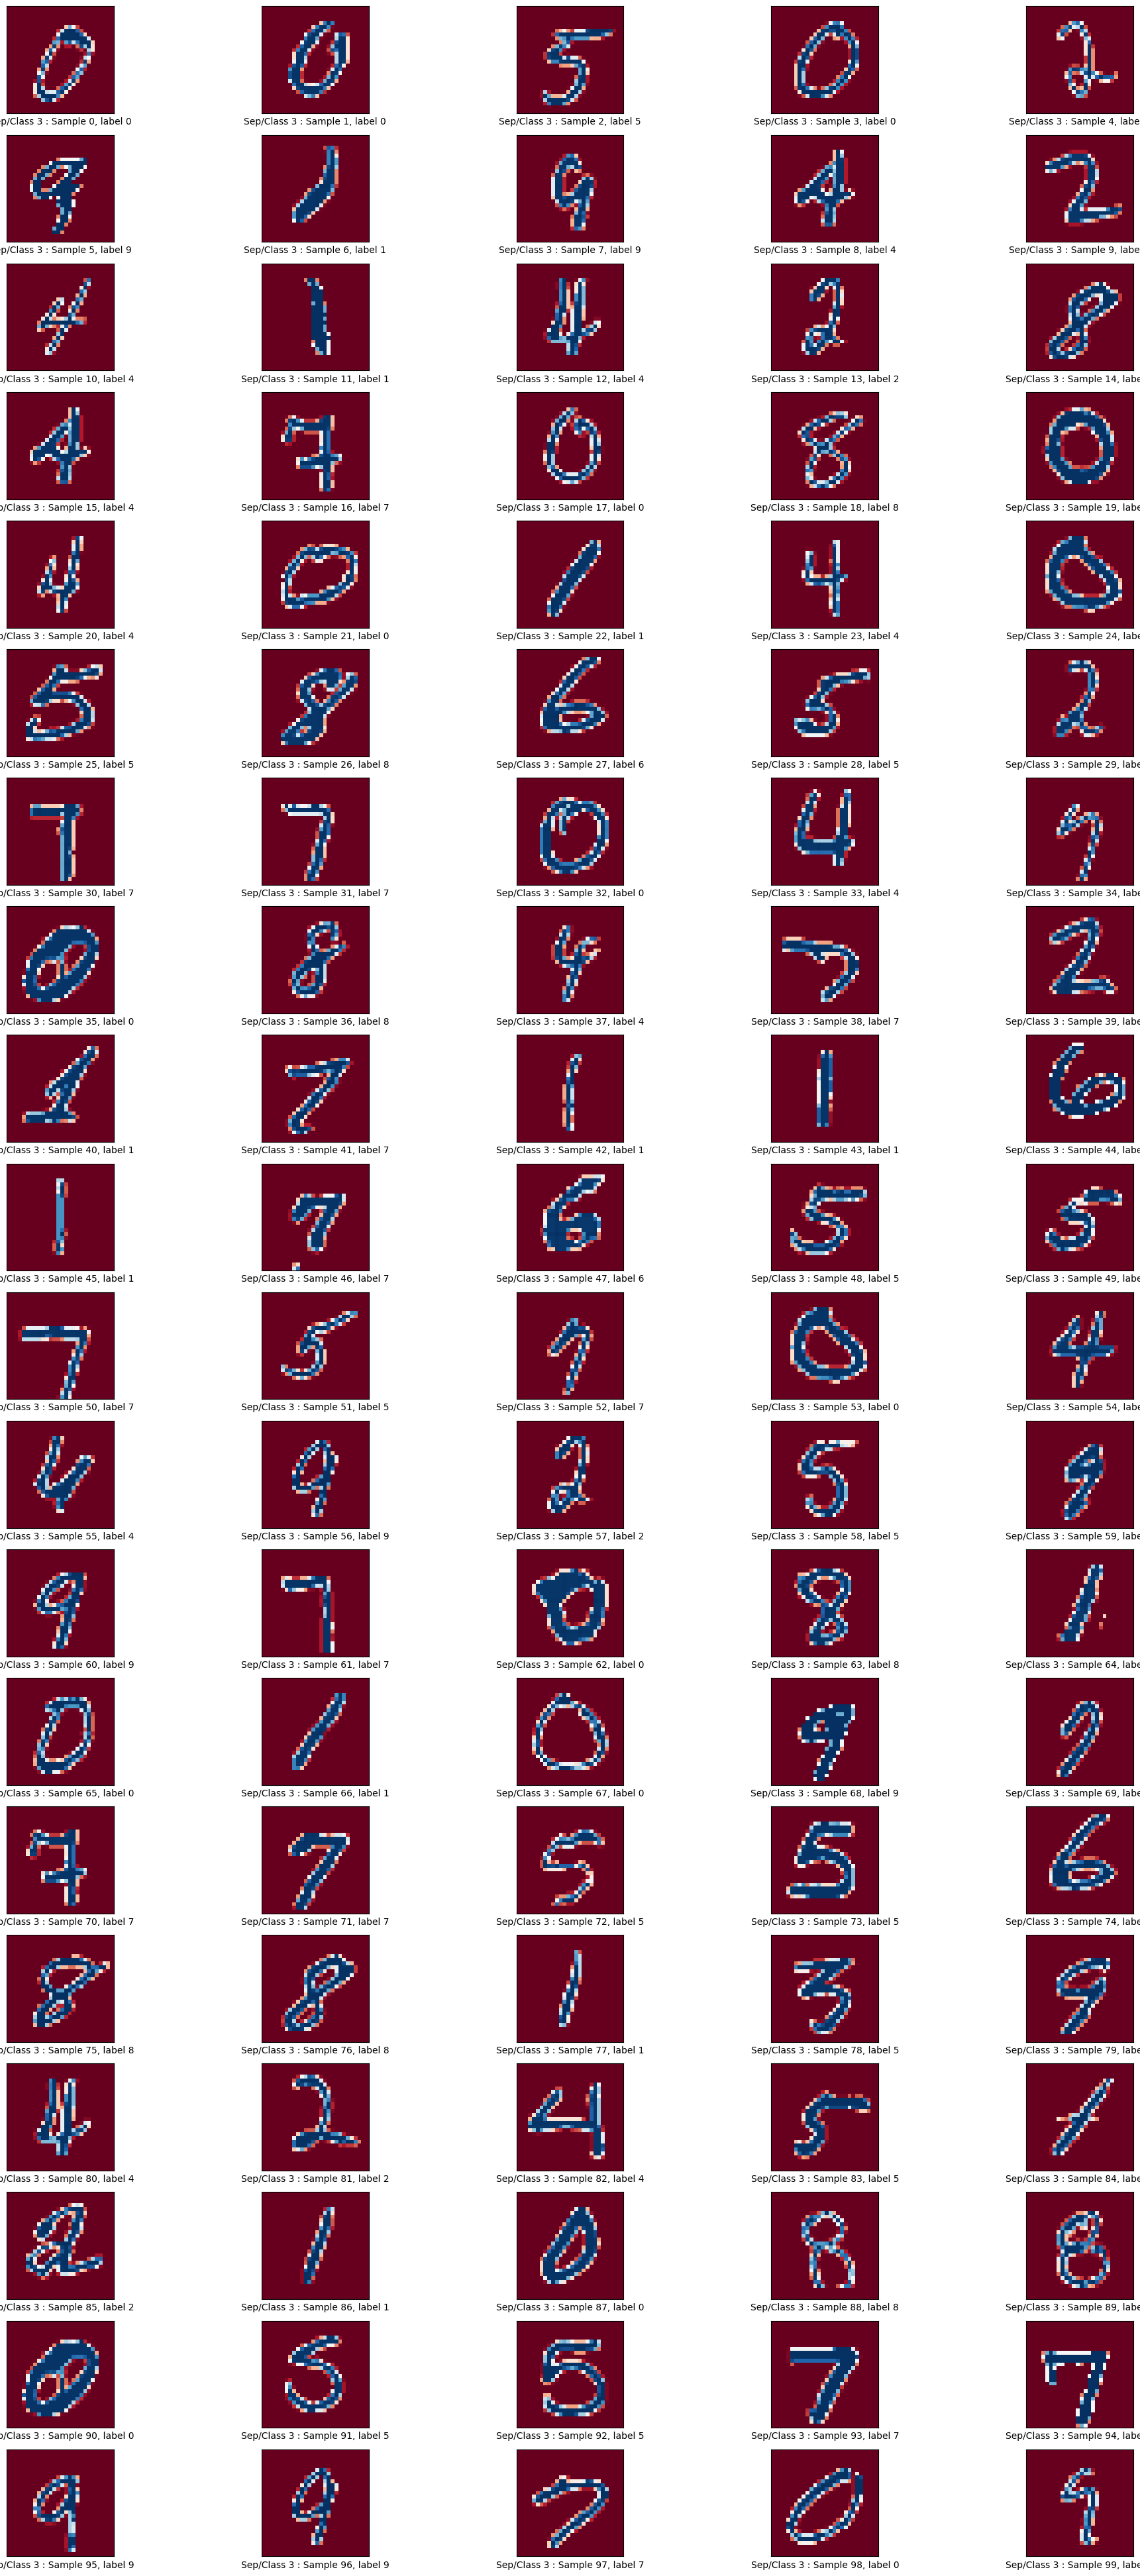

In [7]:
# Plot the mean shapes of the negative supports
neg_supp_samples = train_samp[neg_support,:]
label_neg        = trlab_samp[neg_support]

av_train = neg_supp_samples.mean(axis=0).reshape(-1, 28, 28) 
fig = plt.figure(figsize=(5,5))
plt.imshow(av_train.reshape(28, 28), cmap=plt.cm.RdBu)
fig.savefig("SVM_3_mean_negative_support_%s_%d.png" % (type_svm,class_i))
 
ind = 0
fig = plt.figure(figsize=(24,50))
for i, sample_id in enumerate(chosen_sample):
  l1 = plt.subplot(int(len(chosen_sample)/5), 5, i + 1)   
  sv_image = neg_supp_samples[sample_id,:]
  sv_label = label_neg[sample_id]
  l1.imshow(sv_image.reshape(28, 28), cmap=plt.cm.RdBu)
  l1.set_xticks(())
  l1.set_yticks(())
  l1.set_xlabel('Sep/Class %d : Sample %d, label %s' % (class_i, i, str(sv_label))) 

fig.savefig("SVM_3_negative_support_%s_%d.png" % (type_svm,class_i))

### Calculate the histogram of the labels associated with the positive and negative supports

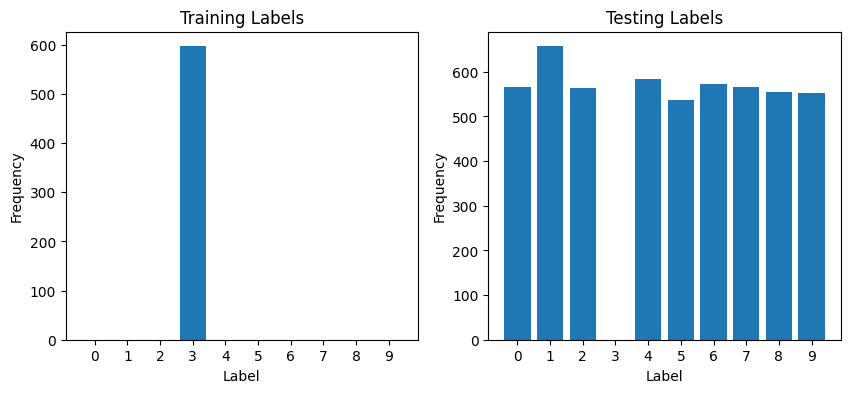

In [8]:
# Calculate the histogram of the labels associated with the positive and negative supports
pos_hist, pos_bins =  np.histogram(label_pos, range=[0,10])
neg_hist, neg_bins =  np.histogram(label_neg, range=[0,10])

width = 0.8
ticks = np.arange(10)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4)) 
ax = axes[0]
ax.bar(range(10), pos_hist, width, label='Training')
ax.set_xticks(ticks)
ax.set_ylabel('Frequency')
ax.set_xlabel('Label')
ax.set_title('Training Labels')
 
ax = axes[1] 
ax.bar(range(10), neg_hist, width, label='Testing')
ax.set_xticks(ticks)
ax.set_ylabel('Frequency')
ax.set_xlabel('Label')
ax.set_title('Testing Labels')

plt.show()
fig.savefig("SVM_3_MNIST_neg_pos_distribution_%s_%d.png" % (type_svm,class_i))